In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
REV_DIR = os.getcwd()
RES_DIR = os.path.dirname(REV_DIR)
ROOT_DIR = os.path.dirname(RES_DIR)
sys.path.append(ROOT_DIR)

In [2]:
from results.revision.revision_utils import get_cnv_only_case, DATA_PATH
from utils.serialization_ops import load_pickle
from core.data_model import PatientDataSet

patient_dataset = load_pickle(DATA_PATH)

In [3]:
import mlflow
import pandas as pd
from sklearn.metrics import auc, roc_curve

from results.revision.revision_utils import  TRACKING_URI, GENE_SPLIT_ID
from utils.serialization_ops import load_pickle
mlflow.set_tracking_uri(TRACKING_URI)

path = mlflow.artifacts.download_artifacts("mlflow-artifacts:/6/{run_id}/artifacts/fold_result.pickle".format(run_id=GENE_SPLIT_ID))
fold_results = load_pickle(path)

/data2/heon_dev/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
fold_results["test_ids"]

[]

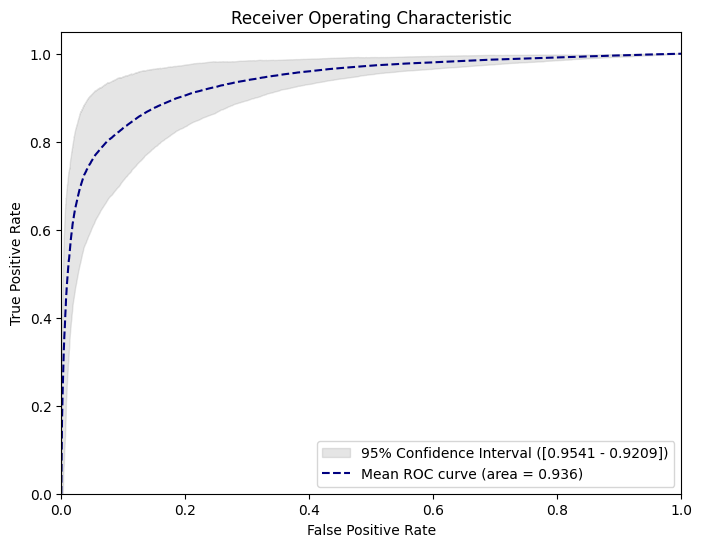

In [4]:
from matplotlib import pyplot as plt
from core.metric import plot_cv_auroc_ci

fold_y_trues = fold_results["fold_bag_y_trues"]
fold_y_probs = fold_results["fold_bag_y_probs"]

plot_cv_auroc_ci(fold_y_trues, fold_y_probs)

------------------------------AVG------------------------------
[74.12576385 88.39542677 92.42460083 94.15730337 94.81569091 96.31381825
 96.72383205 96.92686773 98.09974374]
------------------------------SD------------------------------
[3.64937972 2.40513178 1.61190015 1.52944839 1.53651524 1.55641534
 1.47909308 1.45308346 1.23194796]


<Axes: >

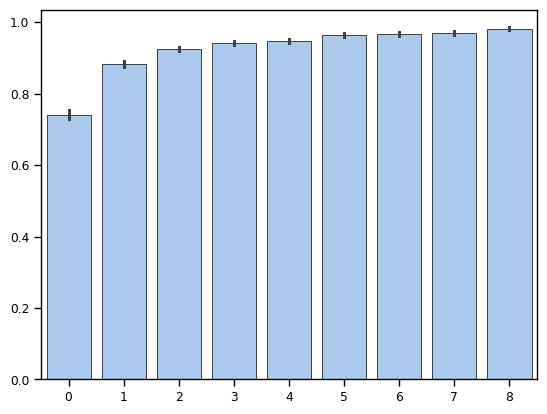

In [5]:
import numpy as np
import pandas as pd
from core.metric import topk_recall
from results.revision.revision_utils import get_topk_folds
import seaborn as sns
sns.set_context('paper')
sns.set_color_codes('pastel')

performnace_snv_cnv = get_topk_folds(
    fold_results["fold_instance_y_trues"],
    fold_results["fold_instance_y_probs"]
)
print("-"*30 + "AVG" + "-"*30)
print(performnace_snv_cnv.mean(axis=0) * 100)
print("-"*30 + "SD" + "-"*30)
print(performnace_snv_cnv.std(axis=0) * 100)
sns.barplot(performnace_snv_cnv, color="b", edgecolor="black", linewidth=0.5)

------------------------------AVG------------------------------
[nan nan nan nan nan nan nan nan nan]
------------------------------SD------------------------------
[nan nan nan nan nan nan nan nan nan]


/tmp/ipykernel_38537/4056597521.py:20: RuntimeWarning: Mean of empty slice.
  print(performnace_cnv.mean(axis=0) * 100)


<Axes: >

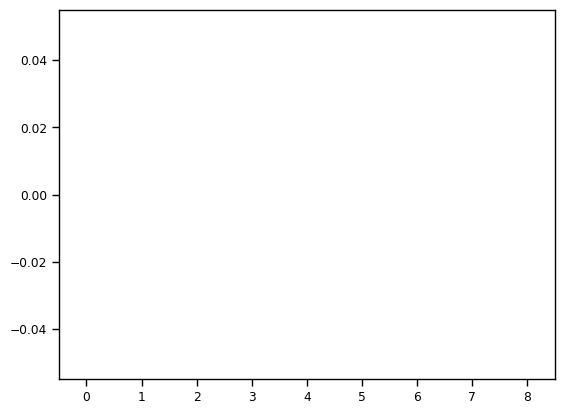

In [9]:
from results.revision.revision_utils import get_cnv_only_case

n_folds = len(fold_results["test_ids"])
fold_results_cnv = {"fold_instance_y_trues":list(), "fold_instance_y_probs":list()}
for fold_idx in range(n_folds):
    test_ids = fold_results["test_ids"][fold_idx]
    cnv_only_ids = get_cnv_only_case(patient_dataset[test_ids])  
    
    test_indices = [test_ids.index(snv_id) for snv_id in cnv_only_ids]
    instance_y_trues = [fold_results["fold_instance_y_trues"][fold_idx][_id] for _id in test_indices]
    instance_y_probs = [fold_results["fold_instance_y_probs"][fold_idx][_id] for _id in test_indices]
    fold_results_cnv["fold_instance_y_trues"].append(instance_y_trues)
    fold_results_cnv["fold_instance_y_probs"].append(instance_y_probs)

performnace_cnv = get_topk_folds(
    fold_results_cnv["fold_instance_y_trues"],
    fold_results_cnv["fold_instance_y_probs"]
) 
print("-"*30 + "AVG" + "-"*30)
print(performnace_cnv.mean(axis=0) * 100)
print("-"*30 + "SD" + "-"*30)
print(performnace_cnv.std(axis=0) * 100)
sns.barplot(performnace_cnv, color="b", edgecolor="black", linewidth=0.5)